In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm

In [4]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string], '')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

In [43]:
DATA_IN_PATH = './datas/'
DATA_OUT_PATH = './datas/'
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

In [9]:
SEED_NUM = 13
tf.random.set_seed(SEED_NUM)

In [10]:
train_input = np.load(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'rb'))
train_label = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [14]:
# prepro_configs

In [16]:
model_name = 'rnn_classifier_en'
BATCH_SIZE = 128
NUM_EPOCHS = 5
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name' : model_name,
'vocab_size' : prepro_configs['vocab_size'],
'embedding_dimension' : 100,
'dropout_rate' : 0.2,
'lstm_dimension' : 150,
'dense_dimension' : 150,
'output_dimension' : 1}

In [25]:
class RNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(RNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'], output_dim=kargs['embedding_dimension'])
        self.lstm_1_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'], return_sequences=True)
        self.lstm_2_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'])
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['dense_dimension'], activation=tf.keras.activations.tanh)
        self.fc2 = layers.Dense(units=kargs['output_dimension'], activation=tf.keras.activations.sigmoid)

    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.lstm_1_layer(x)
        x = self.lstm_2_layer(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [26]:
model = RNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [27]:
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1)

In [28]:
checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print('{} -- Folder already exists \n'.format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print('{} -- Folder create complete \n'.format(checkpoint_dir))

cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./datas/rnn_classifier_en -- Folder already exists 



In [29]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/5
176/176 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5068
Epoch 00001: val_accuracy improved from -inf to 0.51080, saving model to ./datas/rnn_classifier_en\weights.h5
176/176 [==============================] - 253s 1s/step - loss: 0.6931 - accuracy: 0.5068 - val_loss: 0.6927 - val_accuracy: 0.5108
Epoch 2/5
176/176 [==============================] - ETA: 0s - loss: 0.6901 - accuracy: 0.5104
Epoch 00002: val_accuracy improved from 0.51080 to 0.58320, saving model to ./datas/rnn_classifier_en\weights.h5
176/176 [==============================] - 228s 1s/step - loss: 0.6901 - accuracy: 0.5104 - val_loss: 0.6569 - val_accuracy: 0.5832
Epoch 3/5
176/176 [==============================] - ETA: 0s - loss: 0.3698 - accuracy: 0.8395
Epoch 00003: val_accuracy improved from 0.58320 to 0.87440, saving model to ./datas/rnn_classifier_en\weights.h5
176/176 [==============================] - 226s 1s/step - loss: 0.3698 - accuracy: 0.8395 - val_loss: 0.2946 - val_

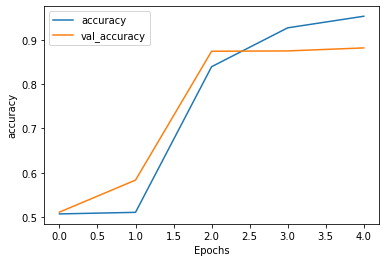

In [30]:
plot_graphs(history, 'accuracy')

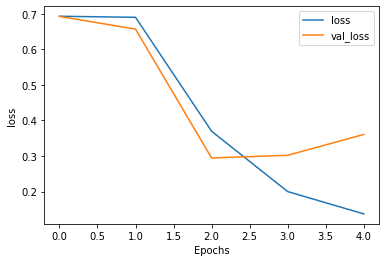

In [31]:
plot_graphs(history, 'loss')

In [35]:
DATA_OUT_PATH = './datas/'
TEST_INPUT_DATA = 'test_input.npy'
TEST_ID_DATA = 'test_id.npy'

test_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])

In [36]:
SAVE_FILE_NM = 'weights.h5'

model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [37]:
predictions = model.predict(test_input, batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)
predictions

array([0.9979252 , 0.00386205, 0.9282241 , ..., 0.00897595, 0.9960686 ,
       0.5381189 ], dtype=float32)

In [38]:
test_id = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'), allow_pickle=True)

if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

output = pd.DataFrame(data={'id' : list(test_id), 'sentiment' : list(predictions)})
output.to_csv(DATA_OUT_PATH + 'movie_review_result_rnn.csv', index=False, quoting=3)

In [44]:
pd.read_csv('./datas/movie_review_result_rnn.csv')[:15]

,id,sentiment
0,12311_10,0.997925
1,8348_2,0.003862
2,5828_4,0.928224
3,7186_2,0.907527
4,12128_7,0.993584
5,2913_8,0.953593
6,4396_1,0.009109
7,395_2,0.956545
8,10616_1,0.002111
9,9074_9,0.055065


In [45]:
model_name = 'cnn_classifier_en'
BATCH_SIZE = 512
NUM_EPOCHS = 5
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name' : model_name,
'vocab_size' : prepro_configs['vocab_size'],
'embedding_size' : 128,
'num_filters' : 100,
'dropout_rate' : 0.5,
'hidden_dimension' : 250,
'output_dimension' : 1}

In [46]:
class CNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'], output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'], kernel_size=kernel_size, padding='valid', activation=tf.keras.activations.relu, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.)) for kernel_size in [3,4,5]]
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'], activation=tf.keras.activations.relu, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'], activation=tf.keras.activations.sigmoid, kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))

    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

In [47]:
model = CNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [48]:
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print('{} -- Folder already exists \n'.format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print('{} -- Folder create complete \n'.format(checkpoint_dir))

cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./datas/cnn_classifier_en -- Folder create complete 



In [49]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/5
44/44 [==============================] - ETA: 0s - loss: 0.6671 - accuracy: 0.6365
Epoch 00001: val_accuracy improved from -inf to 0.78200, saving model to ./datas/cnn_classifier_en\weights.h5
44/44 [==============================] - 68s 2s/step - loss: 0.6671 - accuracy: 0.6365 - val_loss: 0.5424 - val_accuracy: 0.7820
Epoch 2/5
44/44 [==============================] - ETA: 0s - loss: 0.3673 - accuracy: 0.8424
Epoch 00002: val_accuracy improved from 0.78200 to 0.86960, saving model to ./datas/cnn_classifier_en\weights.h5
44/44 [==============================] - 61s 1s/step - loss: 0.3673 - accuracy: 0.8424 - val_loss: 0.3117 - val_accuracy: 0.8696
Epoch 3/5
44/44 [==============================] - ETA: 0s - loss: 0.2124 - accuracy: 0.9197
Epoch 00003: val_accuracy improved from 0.86960 to 0.88240, saving model to ./datas/cnn_classifier_en\weights.h5
44/44 [==============================] - 61s 1s/step - loss: 0.2124 - accuracy: 0.9197 - val_loss: 0.3014 - val_accuracy: 0.882

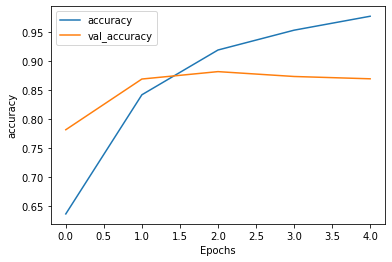

In [50]:
plot_graphs(history, 'accuracy')

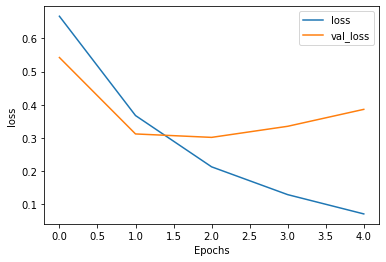

In [51]:
plot_graphs(history, 'loss')

In [52]:
SAVE_FILE_NM = 'weights.h5'

model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [53]:
predictions = model.predict(test_input, batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)

In [54]:
output = pd.DataFrame(data={'id' : list(test_id), 'sentiment' : list(predictions)})
output.to_csv(DATA_OUT_PATH + 'movie_review_result_cnn.csv', index=False, quoting=3)

In [55]:
pd.read_csv('./datas/movie_review_result_cnn.csv')[:15]

,id,sentiment
0,12311_10,0.997555
1,8348_2,0.023249
2,5828_4,0.649192
3,7186_2,0.252048
4,12128_7,0.584986
5,2913_8,0.770239
6,4396_1,0.006467
7,395_2,0.414294
8,10616_1,0.005848
9,9074_9,0.400034
